## **DL for speech speed recognition**

The idea is to investigate how LD could recognize the different speaking pace
The data was collected from youtube videos, the video was of different length and from 5 different people for both classes: 100 words per min and 150 words per min.
Each of videos were converted to audio files and split to 5 second files.

## Context:
Total number of files: 600

Length of one fie: 5 s

number of classes: 2 (100 wpm and 150 wpm)



## Goal:
To build a DL model testing few architectures to predict the speed of human speech.


## **Importing the data**
Data:

Preparing environment and importing libraries

In [0]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

In [0]:
# !pip uninstall tqdm
# !pip install tqdm

In [0]:
SETUP = False

In [4]:
if SETUP:
    !pip install -q -U toai
    !pip install -q -U nb_black
    !pip install -q -U tensorflow-datasets
    !pip install -q -U --no-deps tensorflow-addons~=0.6
print(__import__("toai").__version__)
print(__import__("tensorflow").__version__)

0.5.1
2.1.0


In [0]:
import os

In [0]:
from toai.imports import *
from toai.data import DataBundle, DataParams, DataContainer, split_df
from toai.encode import CategoricalEncoder
from toai.extract import Extractor
from toai.data.utils import split_df
from toai.inpute import CategoricalInputer, NumericInputer
from toai.models import save_keras_model, load_keras_model
from toai.metrics import sparse_top_2_categorical_accuracy
from toai.image import(
    ImageLearner,
    ImageAugmentor,
    ImageDataBundle,
    ImageParser,
    ImageResizer,
    LearningRateFinder,
    ImageTrainingCycle,
    ImageTrainer,
)

In [6]:
from toai.imports import *
import tensorflow as tf
from tensorflow import keras
import efficientnet.tfkeras as efn
%matplotlib inline
import matplotlib.pyplot as plt
from typing import *
import librosa
import librosa.display

/usr/local/lib/python3.6/dist-packages/toai/imports.py:69: UserWarning: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
  warnings.warn(str(error))


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Data preparation and analysis**

In [0]:
DATA_DIR = Path("/content/drive/My Drive/DL project/Training")
TEMP_DIR = Path('/content/drive/My Drive/DL project/models')
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

**Functions to convert audio to spectrograms and prepare data for training**

We create the data frame to prepare data for training

In [0]:
import re
def get_dataframe(path):
    filenames = os.listdir(path)
    if ".ipynb_checkpoints" in filenames:
        filenames.remove(".ipynb_checkpoints")
    data = pd.DataFrame({"filenames": filenames})
    data["labels"] = data.filenames.map(lambda x: re.search(r"^[^_]*", x).group(0))
    data["filenames"] = data.filenames.map(lambda x: os.path.join(DATA_DIR, x))
    return data 

In [0]:
full_df = get_dataframe(DATA_DIR)

In [19]:
full_df

,filenames,labels
0,/content/drive/My Drive/DL project/Training2/1...,100wpm
1,/content/drive/My Drive/DL project/Training2/1...,100wpm
2,/content/drive/My Drive/DL project/Training2/1...,100wpm
3,/content/drive/My Drive/DL project/Training2/1...,100wpm
4,/content/drive/My Drive/DL project/Training2/1...,100wpm
...,...,...
662,/content/drive/My Drive/DL project/Training2/1...,150wpm
663,/content/drive/My Drive/DL project/Training2/1...,150wpm
664,/content/drive/My Drive/DL project/Training2/1...,150wpm
665,/content/drive/My Drive/DL project/Training2/1...,150wpm


In [21]:
full_df.head().T

,0,1,2,3,4
filenames,/content/drive/My Drive/DL project/Training2/1...,/content/drive/My Drive/DL project/Training2/1...,/content/drive/My Drive/DL project/Training2/1...,/content/drive/My Drive/DL project/Training2/1...,/content/drive/My Drive/DL project/Training2/1...
labels,100wpm,100wpm,100wpm,100wpm,100wpm


In [22]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 2 columns):
filenames    667 non-null object
labels       667 non-null object
dtypes: object(2)
memory usage: 10.5+ KB


In [23]:
full_df.labels.unique()

array(['100wpm', '150wpm'], dtype=object)

In [0]:
full_df.to_csv(TEMP_DIR/'full_df.csv', index=False)

In [0]:
full_df = pd.read_csv(TEMP_DIR/'full_df.csv')

Image distribution by label

In [26]:
full_df.groupby('labels')['filenames'].nunique()

labels
100wpm    237
150wpm    430
Name: filenames, dtype: int64

Text(0.5, 1.0, 'All images distribution by labels')

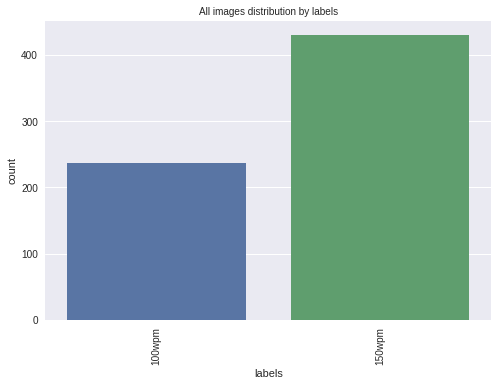

In [27]:
plt.style.use('seaborn')
sns.countplot(full_df['labels'].sort_values(), data=full_df)
plt.xticks(rotation=90)
plt.title('All images distribution by labels', fontsize=10)

## **Data preprocessing**

In [0]:
data_raw = pd.read_csv(TEMP_DIR/'full_df.csv')

In [0]:
train_df, val_df = train_test_split(data_raw, test_size=0.2)
val_df, test_df = train_test_split(val_df, test_size=0.5)

In [30]:
train_df

,filenames,labels
154,/content/drive/My Drive/DL project/Training2/1...,100wpm
473,/content/drive/My Drive/DL project/Training2/1...,150wpm
13,/content/drive/My Drive/DL project/Training2/1...,100wpm
377,/content/drive/My Drive/DL project/Training2/1...,150wpm
325,/content/drive/My Drive/DL project/Training2/1...,150wpm
...,...,...
254,/content/drive/My Drive/DL project/Training2/1...,150wpm
591,/content/drive/My Drive/DL project/Training2/1...,150wpm
598,/content/drive/My Drive/DL project/Training2/1...,150wpm
590,/content/drive/My Drive/DL project/Training2/1...,150wpm


In [0]:
SPECTR_LENGTH = 72
AUDIO_LENGTH = 5
BATCH_SIZE = 32

In [349]:
#feature set
y,sr=librosa.load(DATA_DIR/"100wpm_1_00.wav")
mfccs = librosa.feature.mfcc(y, sr, n_mfcc=40)
melspectrogram =librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000)
chroma_stft=librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=40)
chroma_cq =librosa.feature.chroma_cqt(y=y, sr=sr,n_chroma=40)
chroma_cens =librosa.feature.chroma_cens(y=y, sr=sr,n_chroma=40)
melspectrogram.shape,chroma_stft.shape,chroma_cq.shape,chroma_cens.shape,mfccs.shape

((40, 753), (40, 753), (40, 753), (40, 753), (40, 753))

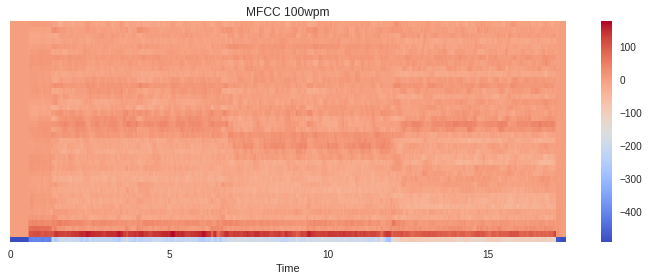

In [355]:
#MFCC of audio 100wpm
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC 100wpm')
plt.tight_layout()

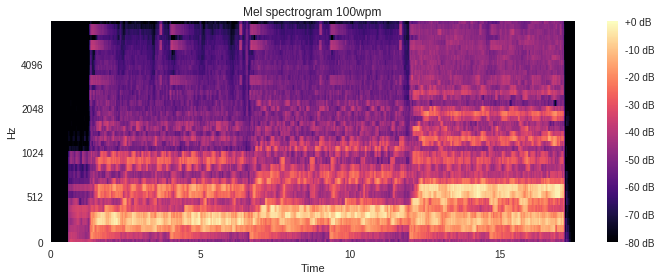

In [356]:
#Melspectrogram of audio 100wpm
plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.power_to_db(melspectrogram,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram 100wpm')
plt.tight_layout()

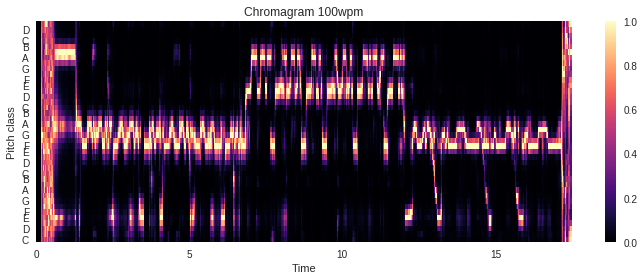

In [357]:
#Chromagram of image
plt.figure(figsize=(10,4))
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram 100wpm')
plt.tight_layout()

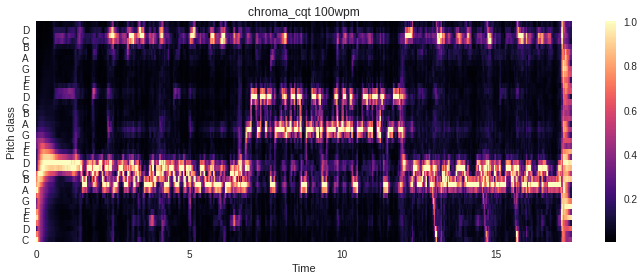

In [358]:
#Chroma cqt of image
plt.figure(figsize=(10,4))
librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('chroma_cqt 100wpm')
plt.tight_layout()

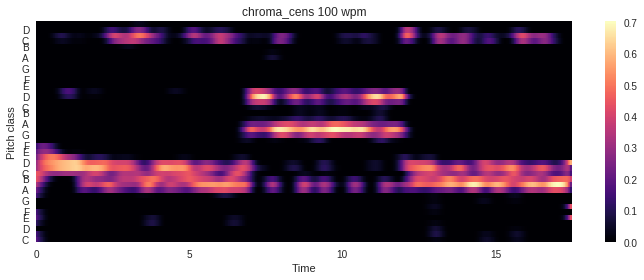

In [359]:
#Chroma cens of audio 100wpm
plt.figure(figsize=(10,4))
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('chroma_cens 100 wpm')
plt.tight_layout()

We will use only mel spectrograms for further datapreparation, as this type helps extract the most suficient info for models

**Function for converting udio file to spetrograms**

In [0]:
def make_spectrogram(filename: str, n_mels: int = 40):
    waveform, sr = librosa.load(filename, sr=22050)
    spectrogram = librosa.feature.melspectrogram(waveform, sr=sr, n_mels=n_mels)
    return np.array(spectrogram)

In [0]:
from tqdm.auto import tqdm
tqdm.pandas()

data_raw["audio_spectro"] = data_raw.filenames.progress_map(lambda x: make_spectrogram(x, 72))

In [0]:
data_raw.to_csv(TEMP_DIR/"data_spectr_72.csv")
np.save(TEMP_DIR/"audio_spectro_72.npy", data_raw.audio_spectro.to_numpy())

In [0]:
data_raw = pd.read_csv(TEMP_DIR/"data_spectr_72.csv")

In [0]:
data_raw["audio_spectro"] = np.load(TEMP_DIR/"audio_spectro_72.npy", allow_pickle=True)

In [0]:
# from tqdm.auto import tqdm
# tqdm.pandas()

# train_df["audio_spectro"] = train_df.filenames.progress_map(lambda x: make_spectrogram(x, 72))

In [0]:
train_df.to_csv(TEMP_DIR/"data_spectr_72_train.csv")
np.save(TEMP_DIR/"audio_spectro_72_train.npy", train_df.audio_spectro.to_numpy())

In [0]:
train_data_raw = pd.read_csv(TEMP_DIR/"data_spectr_72_train.csv")

In [0]:
train_data_raw["audio_spectro"] = np.load(TEMP_DIR/"audio_spectro_72_train.npy", allow_pickle=True)

In [0]:
# from tqdm.auto import tqdm
# tqdm.pandas()

# val_df["audio_spectro"] = val_df.filenames.progress_map(lambda x: make_spectrogram(x, 72))

In [0]:
# val_df.to_csv(TEMP_DIR/"data_spectr_72_val.csv")
# np.save(TEMP_DIR/"audio_spectro_72_val.npy", val_df.audio_spectro.to_numpy())

In [0]:
val_data_raw = pd.read_csv(TEMP_DIR/"data_spectr_72_val.csv")

In [0]:
val_data_raw["audio_spectro"] = np.load(TEMP_DIR/"audio_spectro_72_val.npy", allow_pickle=True)

In [0]:
# from tqdm.auto import tqdm
# tqdm.pandas()

# test_df["audio_spectro"] = test_df.filenames.progress_map(lambda x: make_spectrogram(x, 72))

In [0]:
# test_df.to_csv(TEMP_DIR/"data_spectr_72_test.csv")
# np.save(TEMP_DIR/"audio_spectro_72_test.npy", test_df.audio_spectro.to_numpy())

In [0]:
test_data_raw = pd.read_csv(TEMP_DIR/"data_spectr_72_test.csv")

In [0]:
test_data_raw["audio_spectro"] = np.load(TEMP_DIR/"audio_spectro_72_test.npy", allow_pickle=True)

In [320]:
data_raw.head()

,Unnamed: 0,filenames,labels,audio_spectro
0,0,/content/drive/My Drive/DL project/Training2/1...,100wpm,"[[0.004074333433883479, 0.0015211429160306535,..."
1,1,/content/drive/My Drive/DL project/Training2/1...,100wpm,"[[0.0005365903264121007, 0.0003202957023689485..."
2,2,/content/drive/My Drive/DL project/Training2/1...,100wpm,"[[0.0019761133960387355, 0.0008788137434196683..."
3,3,/content/drive/My Drive/DL project/Training2/1...,100wpm,"[[0.00031604924839762484, 0.001526526450846169..."
4,4,/content/drive/My Drive/DL project/Training2/1...,100wpm,"[[0.001037512637059588, 0.000495283868530773, ..."


In [321]:
train_data_raw.head()

,Unnamed: 0,filenames,labels,audio_spectro
0,154,/content/drive/My Drive/DL project/Training2/1...,100wpm,"[[2.883442226296547e-07, 0.0001051604460807569..."
1,473,/content/drive/My Drive/DL project/Training2/1...,150wpm,"[[7.760591830412859e-07, 4.559504020704411e-07..."
2,13,/content/drive/My Drive/DL project/Training2/1...,100wpm,"[[0.0011759153314247661, 0.0013172757114918079..."
3,377,/content/drive/My Drive/DL project/Training2/1...,150wpm,"[[4.676873578519496e-05, 1.7704461411820907e-0..."
4,325,/content/drive/My Drive/DL project/Training2/1...,150wpm,"[[2.543469285065835e-05, 1.2036330183800516e-0..."


In [322]:
val_data_raw.head()

,Unnamed: 0,filenames,labels,audio_spectro
0,510,/content/drive/My Drive/DL project/Training2/1...,150wpm,"[[0.01742243096264563, 0.011540541127713863, 0..."
1,329,/content/drive/My Drive/DL project/Training2/1...,150wpm,"[[6.303127422968165e-07, 6.337035678223025e-07..."
2,487,/content/drive/My Drive/DL project/Training2/1...,150wpm,"[[0.03377900823305284, 0.04561216005612411, 0...."
3,20,/content/drive/My Drive/DL project/Training2/1...,100wpm,"[[0.0016306506796500214, 0.0004843503732743654..."
4,54,/content/drive/My Drive/DL project/Training2/1...,100wpm,"[[0.0001634459453916951, 6.354335350592019e-05..."


In [323]:
test_data_raw.head()

,Unnamed: 0,filenames,labels,audio_spectro
0,413,/content/drive/My Drive/DL project/Training2/1...,150wpm,"[[1.0907526601446552e-05, 1.0964811830292383e-..."
1,5,/content/drive/My Drive/DL project/Training2/1...,100wpm,"[[0.0005092954049761022, 0.0006064739366859742..."
2,494,/content/drive/My Drive/DL project/Training2/1...,150wpm,"[[1.1356346606198528e-05, 3.257542396476326e-0..."
3,253,/content/drive/My Drive/DL project/Training2/1...,150wpm,"[[0.12273133907002316, 0.11591121993344855, 0...."
4,501,/content/drive/My Drive/DL project/Training2/1...,150wpm,"[[9.497469065550587e-07, 2.502490132522432e-07..."


In [0]:
# Split the data
train_data, val_data = train_test_split(data_raw, test_size=0.2)
val_data, test_data = train_test_split(val_data, test_size=0.5)

## **Preprocessing audio**

Making a padding function for files that are longer than we set

In [0]:
def pad_to(sequence, pad_length):
  if sequence.shape[1] < pad_length:
    return np.pad(sequence, ((0,0), (0, pad_length - sequence.shape[1])))
  else:
    return sequence

In [0]:
def sigmoid_array(x):                                        
    return 1 / (1 + np.exp(-x))

In [0]:
def preprocess_audio(dataframe: pd.DataFrame, filename_col: str = "filenames", 
                     label_col: str = "labels", seconds: int = 1, bs=BATCH_SIZE):
    label_map = {
        "100wpm": 0,
        "150wpm": 1,
    }
    xs_cumulative = None
    ys_cumulative = None
    for index_row in dataframe.index:
      spectrogram = dataframe.loc[index_row, filename_col] 
      spectrogram_split = np.split(spectrogram,
                                   list(range(44*seconds, spectrogram.shape[1], 44 * seconds)), axis=1)
      spectrogram_split = [pad_to(spectro, seconds * 44) for spectro in spectrogram_split]
      spectrogram_split = np.stack([spectrogram_split])
      xs = np.squeeze(spectrogram_split)
      xs = (xs - xs.mean()) / xs.std()
      y = data_raw[label_col].map(label_map).loc[index_row]
      ys = np.repeat(y, xs.shape[0])
      if xs_cumulative is None:
        xs_cumulative = xs
        ys_cumulative = ys
      elif xs_cumulative.shape[0] <= bs:
        try:
          xs_cumulative = np.append(xs, xs_cumulative, axis=0)
          ys_cumulative = np.append(ys, ys_cumulative, axis=0)
        except:
          pass
      else:
        if len(xs_cumulative.shape) == 3:
        #   yield tf.constant(np.tanh(xs_cumulative[:bs, ...]), dtype=tf.float32), tf.constant(ys_cumulative[:bs], dtype=tf.int8)
          yield tf.constant(np.clip((xs_cumulative[:bs, ...] + 0.3), a_min=0, a_max=1), dtype=tf.float32), tf.constant(ys_cumulative[:bs], dtype=tf.int8)
          xs_cumulative = None
          ys_cumulative = None
        else: 
          xs_cumulative = None
          ys_cumulative = None

In [0]:
SPECTR_LENGTH = 72
AUDIO_LENGTH = 5
BATCH_SIZE = 4

In [416]:
train_datagen = preprocess_audio(train_data, "audio_spectro", "labels", AUDIO_LENGTH, BATCH_SIZE)
next(train_datagen)[0].shape

TensorShape([4, 72, 220])

In [417]:
val_datagen = preprocess_audio(val_data, "audio_spectro", "labels", AUDIO_LENGTH, BATCH_SIZE)
next(val_datagen)[0].shape

TensorShape([4, 72, 220])

In [418]:
test_datagen = preprocess_audio(test_data, "audio_spectro", "labels", AUDIO_LENGTH, BATCH_SIZE)
next(test_datagen)[0].shape

TensorShape([4, 72, 220])

## **Building data generator**

In [0]:
def set_shapes(inputs, label, input_shape):
    inputs.set_shape(input_shape)
    label.set_shape([input_shape[0],])
    return inputs, label

def data_generator(generator, shuffle=True, input_shape=None):
  ds = tf.data.Dataset.from_generator(lambda: generator, output_types=(tf.float32, tf.int8))
  ds = ds.map(lambda x,y: (tf.stack([x,x,x], axis=-1), y), num_parallel_calls=4)
  ds = ds.map(lambda x,y: (x[:BATCH_SIZE,:SPECTR_LENGTH,:SPECTR_LENGTH], y), num_parallel_calls=4)
  ds = ds.map(lambda x,y: set_shapes(x,y,input_shape), num_parallel_calls=4)
  ds = ds.unbatch()
  if shuffle:
    ds = ds.shuffle(512)
  ds = ds.batch(BATCH_SIZE).cache().repeat().prefetch(4)
  return ds

In [0]:
train_datagen = preprocess_audio(train_data, "audio_spectro", "labels", AUDIO_LENGTH, BATCH_SIZE)
next(train_datagen)[0].shape
train_data = data_generator(train_datagen, input_shape=[BATCH_SIZE,SPECTR_LENGTH,SPECTR_LENGTH,3])

In [0]:
val_datagen = preprocess_audio(val_data, "audio_spectro", "labels", AUDIO_LENGTH, BATCH_SIZE)
next(val_datagen)[0].shape
val_data = data_generator(val_datagen, input_shape=[BATCH_SIZE,SPECTR_LENGTH,SPECTR_LENGTH,3])

In [0]:
test_datagen = preprocess_audio(test_data, "audio_spectro", "labels", AUDIO_LENGTH, BATCH_SIZE)
next(test_datagen)[0].shape
test_data = data_generator(test_datagen, input_shape=[BATCH_SIZE,SPECTR_LENGTH,SPECTR_LENGTH,3])

For debbuging

In [0]:
# for x, y in train_data.take(1000):
#     if x.numpy().min() < 0 or x.numpy().max() > 1:
#         print(x.numpy().min())
#         print(x.numpy().max())
#     assert x.numpy().min() > 0
#     assert x.numpy().max() < 1
        
#     print(x.numpy().min(), x.numpy().max())
#     print(y)

Checking what data generator prepared for the model

In [0]:
# def show(ds, rows: int = 3, cols: int = 6, debug: bool = False):
#     figsize = (4 * cols, 5 * rows) if debug else (3 * cols, 3 * rows)
#     _, ax = plt.subplots(rows, cols, figsize=figsize)

#     for i, (x, y) in enumerate(ds.unbatch().take(rows * cols)):
#         x = x.numpy()
#         y = y.numpy()
#         idx = (i // cols, i % cols) if rows > 1 else i % cols
#         ax[idx].axis("off")
#         ax[idx].imshow(x)
#         ax[idx].set_title(y)

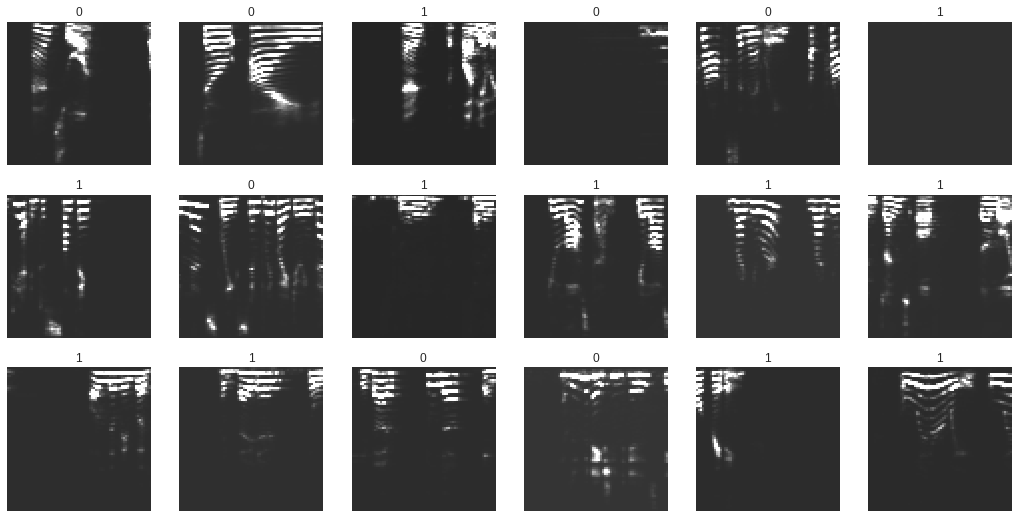

In [244]:
show(train_data)

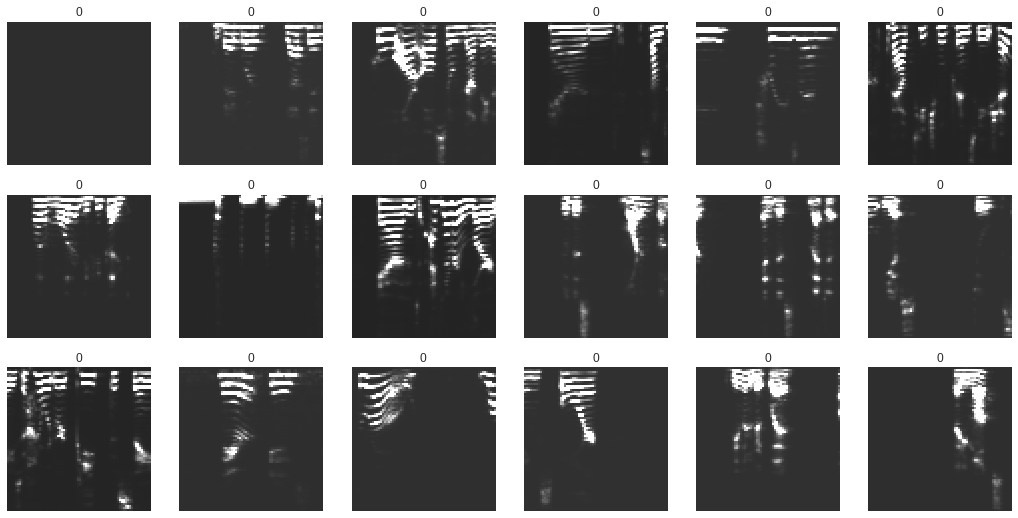

In [245]:
show(val_data)

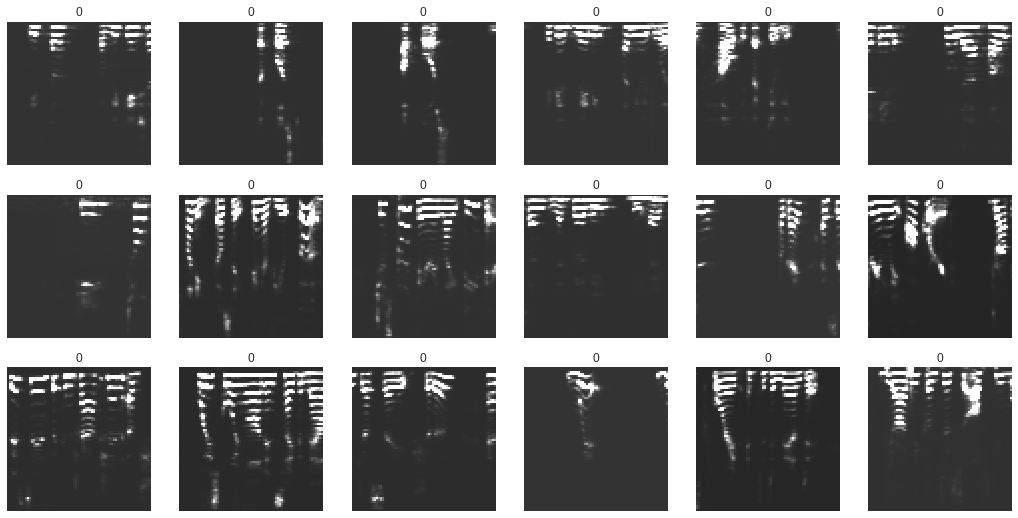

In [248]:
show(test_data)

## **Building the models**

In [0]:
from tensorflow import keras

def model_creator(name,
                  base_model,
                  input_shape,
                  dropout,
                  output_layer) -> keras.Model:
        base_model = base_model(
            include_top=False, input_shape=input_shape)
        concat_layer = keras.layers.concatenate(
            [
                keras.layers.GlobalAvgPool2D()(base_model.output),
                keras.layers.GlobalMaxPool2D()(base_model.output),
            ]
        )

        dropout = keras.layers.Dropout(dropout)(concat_layer)

        output = output_layer(dropout)
        return keras.Model(inputs=base_model.input, outputs=output)

**First model with Xception architecture**

In [0]:
model_1 = model_creator("model_1", keras.applications.Xception, input_shape=(SPECTR_LENGTH,SPECTR_LENGTH,3),
                        dropout=0.5, output_layer=keras.layers.Dense(1, activation="sigmoid"))

In [0]:
model_1.compile(optimizer=keras.optimizers.Adam(1e-5), loss=keras.losses.binary_crossentropy, metrics=["accuracy"])

In [342]:
model_1.fit(train_data, epochs=100, steps_per_epoch=5, validation_data=val_data, validation_steps=5)

Train for 5 steps, validate for 5 steps
Epoch 1/100
5/5 [==============================] - 5s 1s/step - loss: 0.8891 - accuracy: 0.4000 - val_loss: 0.7325 - val_accuracy: 0.5000
Epoch 2/100
5/5 [==============================] - 0s 40ms/step - loss: 0.8092 - accuracy: 0.4000 - val_loss: 0.7162 - val_accuracy: 0.4500
Epoch 3/100
5/5 [==============================] - 0s 41ms/step - loss: 0.6953 - accuracy: 0.5000 - val_loss: 0.7052 - val_accuracy: 0.5000
Epoch 4/100
5/5 [==============================] - 0s 39ms/step - loss: 0.6740 - accuracy: 0.5500 - val_loss: 0.7016 - val_accuracy: 0.5500
Epoch 5/100
5/5 [==============================] - 0s 40ms/step - loss: 0.7723 - accuracy: 0.4500 - val_loss: 0.7034 - val_accuracy: 0.5500
Epoch 6/100
5/5 [==============================] - 0s 39ms/step - loss: 0.6541 - accuracy: 0.6500 - val_loss: 0.7115 - val_accuracy: 0.5500
Epoch 7/100
5/5 [==============================] - 0s 39ms/step - loss: 0.6369 - accuracy: 0.7000 - val_loss: 0.7128 - val

In [343]:
model_1.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 72, 72, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 35, 35, 32)   864         input_10[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 35, 35, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 35, 35, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [347]:
print("Test accuracy:")
print(f"Model 1: {model_1.evaluate(test_data, steps = 0.1*len(data_raw) // 32)}")

Test accuracy:
2/2 [==============================] - 0s 61ms/step - loss: 1816.3665 - accuracy: 0.8750
Model 1: [1816.366510629654, 0.875]


**Second model with ResNet50**

In [0]:
from tensorflow import keras

def model_creator(name,
                  base_model,
                  input_shape,
                  dropout,
                  output_layer) -> keras.Model:
        base_model = base_model(
            include_top=False, input_shape=input_shape)
        concat_layer = keras.layers.concatenate(
            [
                keras.layers.GlobalAvgPool2D()(base_model.output),
                keras.layers.GlobalMaxPool2D()(base_model.output),
            ]
        )

        dropout = keras.layers.Dropout(dropout)(concat_layer)

        output = output_layer(dropout)
        return keras.Model(inputs=base_model.input, outputs=output)

In [0]:
model_2 = model_creator("model_2", keras.applications.ResNet50, input_shape=(SPECTR_LENGTH,SPECTR_LENGTH,3),
                        dropout=0.4, output_layer=keras.layers.Dense(1, activation="sigmoid"))

In [0]:
model_2.compile(optimizer=keras.optimizers.Adam(1e-5), loss=keras.losses.binary_crossentropy, metrics=["accuracy"])

In [378]:
history2=model_2.fit(train_data, epochs=100, steps_per_epoch=5, validation_data=val_data, validation_steps=5)

Train for 5 steps, validate for 5 steps
Epoch 1/100
5/5 [==============================] - 6s 1s/step - loss: 1.5198 - accuracy: 0.5000 - val_loss: 0.6094 - val_accuracy: 0.7000
Epoch 2/100
5/5 [==============================] - 0s 43ms/step - loss: 0.9086 - accuracy: 0.5500 - val_loss: 0.6367 - val_accuracy: 0.7000
Epoch 3/100
5/5 [==============================] - 0s 43ms/step - loss: 1.9242 - accuracy: 0.4000 - val_loss: 0.6522 - val_accuracy: 0.7000
Epoch 4/100
5/5 [==============================] - 0s 43ms/step - loss: 1.2343 - accuracy: 0.5500 - val_loss: 0.6468 - val_accuracy: 0.7000
Epoch 5/100
5/5 [==============================] - 0s 44ms/step - loss: 1.3179 - accuracy: 0.4500 - val_loss: 0.6579 - val_accuracy: 0.7000
Epoch 6/100
5/5 [==============================] - 0s 43ms/step - loss: 0.8652 - accuracy: 0.7500 - val_loss: 0.6816 - val_accuracy: 0.7000
Epoch 7/100
5/5 [==============================] - 0s 43ms/step - loss: 1.5692 - accuracy: 0.6000 - val_loss: 0.6589 - val

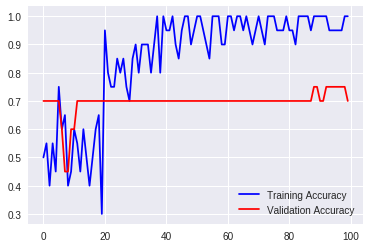

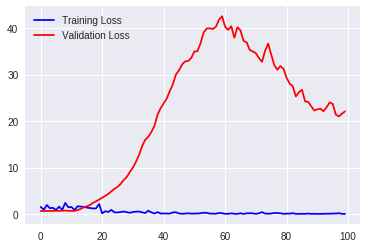

In [379]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()

In [426]:
print("Testing accuracy:")
print(f"Model 2: {model_2.evaluate(test_data, steps = 0.1*len(data_raw) // 32)}")

Testing accuracy:
2/2 [==============================] - 1s 390ms/step - loss: 0.3778 - accuracy: 0.8750
Model 2: [0.37779662758111954, 0.875]


## **Summary**:

**Test loss scores and Accuracy:**

The results for test_data seems much better with model_2 - Resnet50 architecture, than Xception for loss score, and for accuracy is the same.

It seems need for more experimentation finding the reason why such big loss, or the task for DL is to hard, as training results are quite good.